In [3]:
from collections import defaultdict
from datetime import datetime, timedelta, time
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
import pytz

import catboost as cbt
import lightgbm as lgb 
import xgboost as xgb 

In [4]:
# Global variables one needs to set to run code in their system

PATH_FOR_DATASET = '/Users/ashwinsamuel/Documents/Kaggle/closing_auction_prediction/202503_imbalance/'
PATH_TO_READ_SAVE_MODELS = "/Users/ashwinsamuel/Documents/Kaggle/closing_auction_prediction/models/n1000_False_with_mul"
PATH_TO_SAVE_RESULTS = '/Users/ashwinsamuel/Documents/Kaggle/closing_auction_prediction/results/n1000_False_with_mul'
WIDTH = 180
USE_LAST_W_SECONDS = False
WINDOW_MULTIPLIER = 8
USE_SAVED_MODEL = False
SAVE_MODEL = False

# 1 - Loading and cleaning data

* Dataset contains exchange messages after 4 PM too, so filtered out those. It was imp to take into account daylight savings time that starts from 10th March thats whay Ive used timezone aware pandas datetime type. This also got rid of the extra messages for WBA (5.40-5.45 PM) and AAOI (4.30 PM - 4.35 PM) which led to a ~30% jump in the stock due to the post-market deal announcement with Amazon on 13th March.

* Convert timestamp column to pandas datetime. Important for fast vector operations for a large dataset like this

In [21]:
def load_data(path):

    start_date = datetime(2025, 3, 3)
    end_date = datetime(2025, 3, 31)
    all_data = []

    current_date = start_date
    while current_date <= end_date:
        print(f'Getting data for {current_date.date()}')
        if current_date.weekday() < 5:
            filename = current_date.strftime("%Y%m%d") + ".csv"
            df = pd.read_csv(path+filename)
            all_data.append(df)

        current_date += timedelta(days=1) 

    # convert to pandas datetime for fast vector ops
    compiled_df = pd.concat(all_data, ignore_index=True)
    compiled_df['local_time'] = pd.to_datetime(compiled_df['local_time'], utc=True).dt.tz_convert("America/New_York")
    compiled_df['date'] = compiled_df['local_time'].dt.day

    # filter out datapoint after 4PM
    cutoff_time = time(16,0,1)
    compiled_df = compiled_df[ compiled_df['local_time'].dt.time < cutoff_time ]

    return compiled_df

In [22]:
compiled_df = load_data(PATH_FOR_DATASET)

Getting data for 2025-03-03
Getting data for 2025-03-04
Getting data for 2025-03-05
Getting data for 2025-03-06
Getting data for 2025-03-07
Getting data for 2025-03-08
Getting data for 2025-03-09
Getting data for 2025-03-10
Getting data for 2025-03-11
Getting data for 2025-03-12
Getting data for 2025-03-13
Getting data for 2025-03-14
Getting data for 2025-03-15
Getting data for 2025-03-16
Getting data for 2025-03-17
Getting data for 2025-03-18
Getting data for 2025-03-19
Getting data for 2025-03-20
Getting data for 2025-03-21
Getting data for 2025-03-22
Getting data for 2025-03-23
Getting data for 2025-03-24
Getting data for 2025-03-25
Getting data for 2025-03-26
Getting data for 2025-03-27
Getting data for 2025-03-28
Getting data for 2025-03-29
Getting data for 2025-03-30
Getting data for 2025-03-31


* <u>Clean:</u> Grouping by symbol and date, there are ***only*** 331 or 332 rows in the dataset (no duplicates or missing rows). This comes from:
        
        (i) 30 points from 3.50.0 PM - 3.54.50 PM every 10 seconds
        
        (ii) 300 points from 3.55.0 PM - 3.59.59 PM every 1 second
        
        (iii) 1 point at 4.0.0 PM (not always there - thats why some cases have 331 and others have 332 points)
        
        (iv) 1 special exchange message with ref_price=nan and giving the cross price for that date and symbol

In [23]:
# only 331 or 332 rows in the dataset for a symbol per day

per_symbol_date = compiled_df.groupby(['symbol', 'date'], as_index=False).size()
per_symbol_date_count = per_symbol_date['size'].value_counts()
print(per_symbol_date.head(5))

print('\nOnly count of 330s and 331s exist. No other counts exist:')
per_symbol_date_count

  symbol  date  size
0    AAL     3   331
1    AAL     4   331
2    AAL     5   331
3    AAL     6   331
4    AAL     7   331

Only count of 330s and 331s exist. No other counts exist:


331    9264
332    1236
Name: size, dtype: int64

* <u>Clean:</u> Count of rows with ref_prices=nan is 10500 exactly equal to the unique (symbol,date) pairs. So, only the special exchange messages at 4PM with the cross price are the ones with nan ref_prices. No extra unexpected nan ref_prices.

In [24]:
# ref_price = nan count of 10500 makes sense

print(f'Number of unique (symbol,date) pairs is {len(per_symbol_date)}')
nan_count = len(compiled_df[compiled_df['ref_price'].isna()])
print(f'Count of rows with ref_price=nan is {nan_count}')

Number of unique (symbol,date) pairs is 10500
Count of rows with ref_price=nan is 10500


* <u>Not Clean:</u> Some ref_prices are =0. In most cases, they are 0 for the entire day for a symbol (when the row count is 330 or 331). 1 less than 331/332 because 1 point is the special exchange message with the cross price and ref_price=nan. There are 8 cases with some (not all) ref_prices=0 for a day. We're going to filter those days out as its a negligible proportion of the dataset, so not alot to lose and we get the advantage of clean non-zero ref_prices which will help the model to learn better and not skew decisions based on a few 0s.


In [25]:
# Rows with ref_price=0

zero_ref_prices = compiled_df[compiled_df['ref_price']==0]
zeros_per_symbol_date = zero_ref_prices.groupby(['symbol', 'date'], as_index=False).size()

print('Different counts of rows with ref_price=0 per symbol per date:')
zero_counts = zeros_per_symbol_date['size'].value_counts()
print(zero_counts)

Different counts of rows with ref_price=0 per symbol per date:
330    50
331     9
30      4
278     1
8       1
95      1
28      1
Name: size, dtype: int64


In [ ]:
# filter out (symbol,date) pairs with ref_price=0 for any second

compiled_df_clean = compiled_df.merge(zeros_per_symbol_date[['symbol', 'date']], on=['symbol', 'date'], how='left', indicator=True)
compiled_df_clean = compiled_df_clean[compiled_df_clean['_merge']=='left_only'].drop(columns='_merge')

# nan ref_prices only filtered out now. need it for later computation for determining cross prices
compiled_df_clean_without_nan_ref_price = compiled_df_clean[compiled_df_clean['ref_price'].notna()]

* <u>Not clean (other columns):</u> Before above cleaning, there were many problematic columns. But after, there are 2 types of problematic columns left:
        
        (i) 4 bid/ask(qty) columns are the only ones with Nans. -> I've left them as nans because tree models are robust in handling nans and number of rows are also very less. cross is nan for all exchange messages except the special mesg at 4PM
        
        (ii) The columns with zeros. Most are fine. shares and paired_shares can be 0 naturally. open, we dont care about. far_price and near_price are only sent from 3.55 onwards. The 3.50 - 3.55 ones are the 0 ones along with some other random 0s. I have replaced them with nans, as tree models can handle it but 0 can throw the model off.

In [27]:
# General cleaning

def check_invalid_columns(df):
    zeros, nans, negatives =[],[],[]
    for col in df.columns:
        if not df[df[col]==0].empty:
            zeros.append(col)
        
        if not df[df[col].isna()].empty:
            nans.append(col)
        
        if df[col].dtype in [np.float64, np.int64] and not df[df[col]<0].empty:
            negatives.append(col)
    
    print(f'Columns with 0s = {zeros}')
    print(f'Columns with nans = {nans}')
    print(f'Columns with negatives = {negatives}')
    print('Value count for side:')
    print(df['side'].value_counts())
    
    return


print('Before cleaning:')
check_invalid_columns(compiled_df)
print()
print('After removing 0 and nan ref_prices:')
check_invalid_columns(compiled_df_clean_without_nan_ref_price)
print()
print('Rows with nan bid/ask:')

nan_ask_rows = compiled_df_clean_without_nan_ref_price[compiled_df_clean_without_nan_ref_price['ask'].isna()]
print('Only {len(nan_ask_rows)} rows with nan bid/ask(qty) values')
nan_ask_rows

Before cleaning:
Columns with 0s = ['cross', 'far_price', 'near_price', 'open', 'paired_shares', 'ref_price', 'shares']
Columns with nans = ['ask', 'ask_qty', 'bid', 'bid_qty', 'cross', 'far_price', 'near_price', 'paired_shares', 'ref_price', 'shares', 'side']
Columns with negatives = []
Value count for side:
BUY             1312764
SELL            1240089
NONE             893375
INSUFFICIENT      20008
Name: side, dtype: int64

After removing 0 and nan ref_prices:
Columns with 0s = ['far_price', 'near_price', 'open', 'paired_shares', 'shares']
Columns with nans = ['ask', 'ask_qty', 'bid', 'bid_qty', 'cross']
Columns with negatives = []
Value count for side:
BUY     1312259
SELL    1239434
NONE     892420
Name: side, dtype: int64

Rows with nan bid/ask:


,ts,adv,ask,ask_qty,bid,bid_qty,cross,far_price,near_price,open,paired_shares,ref_price,shares,side,symbol,ts.1,local_time,date
497113,2025-03-06 20:50:00.123524058,14652.696,NaN,NaN,NaN,NaN,NaN,0.0,0.0,5.63,923.0,5.48,212.0,BUY,JTAI,2025-03-06 20:50:00.123524058,2025-03-06 15:50:00.123524058-05:00,6
497263,2025-03-06 20:50:10.017496724,14652.696,NaN,NaN,NaN,NaN,NaN,0.0,0.0,5.63,923.0,5.48,212.0,BUY,JTAI,2025-03-06 20:50:10.017496724,2025-03-06 15:50:10.017496724-05:00,6
497936,2025-03-06 20:50:20.031701071,14652.696,NaN,NaN,NaN,NaN,NaN,0.0,0.0,5.63,923.0,5.48,212.0,BUY,JTAI,2025-03-06 20:50:20.031701071,2025-03-06 15:50:20.031701071-05:00,6
498600,2025-03-06 20:50:30.045789322,14652.696,NaN,NaN,NaN,NaN,NaN,0.0,0.0,5.63,923.0,5.48,212.0,BUY,JTAI,2025-03-06 20:50:30.045789322,2025-03-06 15:50:30.045789322-05:00,6
498688,2025-03-06 20:50:40.033975309,14652.696,NaN,NaN,NaN,NaN,NaN,0.0,0.0,5.63,923.0,5.48,212.0,BUY,JTAI,2025-03-06 20:50:40.033975309,2025-03-06 15:50:40.033975309-05:00,6
499327,2025-03-06 20:50:50.017678287,14652.696,NaN,NaN,NaN,NaN,NaN,0.0,0.0,5.63,923.0,5.48,212.0,BUY,JTAI,2025-03-06 20:50:50.017678287,2025-03-06 15:50:50.017678287-05:00,6
500130,2025-03-06 20:51:00.050017700,14652.696,NaN,NaN,NaN,NaN,NaN,0.0,0.0,5.63,923.0,5.48,212.0,BUY,JTAI,2025-03-06 20:51:00.050017700,2025-03-06 15:51:00.050017700-05:00,6
500610,2025-03-06 20:51:10.045634073,14652.696,NaN,NaN,NaN,NaN,NaN,0.0,0.0,5.63,923.0,5.48,212.0,BUY,JTAI,2025-03-06 20:51:10.045634073,2025-03-06 15:51:10.045634073-05:00,6
501092,2025-03-06 20:51:20.043430704,14652.696,NaN,NaN,NaN,NaN,NaN,0.0,0.0,5.63,923.0,5.48,212.0,BUY,JTAI,2025-03-06 20:51:20.043430704,2025-03-06 15:51:20.043430704-05:00,6
501187,2025-03-06 20:51:30.003544397,14652.696,NaN,NaN,NaN,NaN,NaN,0.0,0.0,5.63,923.0,5.48,212.0,BUY,JTAI,2025-03-06 20:51:30.003544397,2025-03-06 15:51:30.003544397-05:00,6


In [28]:
# change far_price and near_price from 0 -> nan

zero_far_prices = compiled_df_clean['far_price']==0
zero_near_prices = compiled_df_clean['near_price']==0
compiled_df_clean.loc[zero_far_prices, 'far_price'] = np.nan
compiled_df_clean.loc[zero_near_prices, 'near_price'] = np.nan
compiled_df_clean[zero_far_prices]

,ts,adv,ask,ask_qty,bid,bid_qty,cross,far_price,near_price,open,paired_shares,ref_price,shares,side,symbol,ts.1,local_time,date
0,2025-03-03 20:50:00.000385287,9644.652,47.69,100.0,47.60,100.0,NaN,NaN,NaN,41.76,260.0,47.68,1695.0,BUY,TSLQ,2025-03-03 20:50:00.000385287,2025-03-03 15:50:00.000385287-05:00,3
1,2025-03-03 20:50:00.000611455,11416.429,9.34,2900.0,9.33,3930.0,NaN,NaN,NaN,9.29,760635.0,9.34,2838.0,BUY,VTRS,2025-03-03 20:50:00.000611455,2025-03-03 15:50:00.000611455-05:00,3
2,2025-03-03 20:50:00.000842662,6302.992,55.16,498.0,55.15,20.0,NaN,NaN,NaN,54.39,595352.0,55.16,153252.0,BUY,MNST,2025-03-03 20:50:00.000842662,2025-03-03 15:50:00.000842662-05:00,3
3,2025-03-03 20:50:00.001359103,2733.872,45.16,1077.0,45.13,428.0,NaN,NaN,NaN,46.92,109876.0,45.16,24462.0,BUY,VNOM,2025-03-03 20:50:00.001359103,2025-03-03 15:50:00.001359103-05:00,3
4,2025-03-03 20:50:00.001413005,44615.097,237.39,200.0,237.35,11.0,NaN,NaN,NaN,241.81,4124347.0,237.35,379460.0,SELL,AAPL,2025-03-03 20:50:00.001413005,2025-03-03 15:50:00.001413005-05:00,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3475084,2025-03-31 19:59:57.107201512,2013.022,50.01,78423.0,50.00,44958.0,NaN,NaN,50.01,50.00,46855.0,50.01,24678.0,BUY,TBIL,2025-03-31 19:59:57.107201512,2025-03-31 15:59:57.107201512-04:00,31
3475330,2025-03-31 19:59:58.056115458,2013.022,50.01,78423.0,50.00,44958.0,NaN,NaN,50.01,50.00,46855.0,50.01,24678.0,BUY,TBIL,2025-03-31 19:59:58.056115458,2025-03-31 15:59:58.056115458-04:00,31
3475504,2025-03-31 19:59:58.104399946,3785.359,82.72,110840.0,82.71,722.0,NaN,NaN,82.72,82.74,634779.0,82.72,95483.0,BUY,SHY,2025-03-31 19:59:58.104399946,2025-03-31 15:59:58.104399946-04:00,31
3475987,2025-03-31 19:59:59.091768662,2013.022,50.01,78423.0,50.00,44958.0,NaN,NaN,50.01,50.00,46855.0,50.01,24678.0,BUY,TBIL,2025-03-31 19:59:59.091768662,2025-03-31 15:59:59.091768662-04:00,31


# 2 - Deciding Target variable (Preprocessing)
* I've modelled the problem as ref_price prediction WIDTH secs later with WIDTH=10,20,...300 secs. This will help us in making an informed decision at all times during the auction period.

* Here, it was important to handle the logic in 4 different time windows for a particular WIDTH=w. It's required because messages from 3.50 - 3.55 are 10 secs apart compared to 1 sec apart for 3.55 - 4.
        
        (i) Time window 1: 3.50 - (3.55-w) -> target_price is simply w/10 rows ahead
        
        (ii) Time window 2: (3.55-w) - 3.55 -> target_price is variable rows ahead (computed by compute_shifts())
        
        (iii) Time window 3: 3.55 - (4.00-w) -> target price is simply w rows ahead
        
        (iv) Time window 4: (4.00-w) - 4.00 -> target price is simply the crossing price at 4.00. There are 2 types of models. Type 1 doesnt use this 4th time window for training and Type 2 does (denoted by bool flag use_last_w_seconds).


* Variables introduced:

        (i) WIDTH - for each exchange message, model is trying to predict the ref_price WIDTH seconds later
        
        (ii) USE_LAST_W_SECONDS - flag denoting whther to use the last WIDTH seconds or not for training

In [29]:
def compute_shifts(width):
    
    set_of_shifts = set()
    
    time = 55*60 - width + 10
    while time<55*60:
        minute = time//60
        seconds = time%60
    
        secs_to_55 = (55 - minute - 1)*60 + 60 - seconds
        secs_after_55 = width - secs_to_55
        to_shift = int(secs_after_55 + secs_to_55/10)
        set_of_shifts.add(to_shift)
    
        time+=10

    return set_of_shifts

def get_target(df, width, use_last_w_seconds):

    df['stock_id'] = pd.factorize(df['symbol'])[0]
    df['seconds'] = df['local_time'].dt.second
    df['minute'] = df['local_time'].dt.minute

    df.sort_values(by=['symbol', 'local_time'], inplace=True)
    
    df[f'ref_price_shift-{width}'] = df['ref_price'].shift(-width) #all
    df[f'ref_price_shift-{int(width/10)}'] = df['ref_price'].shift(-int(width/10)) #cutoff2
    df['next_ref_price'] = df[f'ref_price_shift-{width}']
    
    # other shifts required for this width
    for shift in compute_shifts(width):
        df[f'ref_price_shift-{shift}'] = df['ref_price'].shift(-shift)

    cutoff_time_1 = time(15,55,0)
    condition_1 = df['local_time'].dt.time < cutoff_time_1

    time_in_seconds = 55*60 - width
    while time_in_seconds<55*60:
        m = time_in_seconds//60
        s = time_in_seconds%60
        secs_to_55 = (55 - m - 1)*60 + 60 - s
        secs_after_55 = width - secs_to_55
        to_shift = int(secs_after_55 + secs_to_55/10)

        condition_2 = (df['minute']==m) & (df['seconds']==s)
        df.loc[(condition_1) & (condition_2), 'next_ref_price'] = df.loc[(condition_1) & (condition_2), f'ref_price_shift-{to_shift}']
        print(f'For width={width}: variable shift for {m}m{s}sec done')
        time_in_seconds+=10

    cutoff_time_2 = (datetime(2025,3,3,15,55,0) - timedelta(seconds=width)).time()
    condition_2 = df['local_time'].dt.time < cutoff_time_2
    df.loc[condition_2, 'next_ref_price'] = df.loc[condition_2, f'ref_price_shift-{int(width/10)}']

    cutoff_datetime_3 = datetime(2025,3,3,16,0,0) - timedelta(seconds=width)
    final_cross = df.groupby(['symbol', 'date'], as_index=False)['cross'].last().rename(columns={'cross': 'final_cross'})
    df = df.merge(final_cross, on=['symbol', 'date'], how='left')

    if use_last_w_seconds:    
        condition_3 = df['local_time'].dt.time > cutoff_datetime_3.time()
        df.loc[condition_3, 'next_ref_price'] = df.loc[condition_3, 'final_cross']
        df.dropna(subset='ref_price', inplace=True)
    else:

        m,s = cutoff_datetime_3.minute, cutoff_datetime_3.second
        last_valid_rows = (df['minute']==m) & (df['seconds']==s)
        df.loc[last_valid_rows, 'next_ref_price'] = df.loc[last_valid_rows, 'final_cross']

        cutoff_datetime_3 = cutoff_datetime_3 + timedelta(seconds=1)
        condition_3 = df['local_time'].dt.time > cutoff_datetime_3.time()
        df = df[~condition_3]

    df.sort_values(by='local_time', inplace=True)
    df=df.copy()

    return df['next_ref_price']

In [30]:
target = get_target(compiled_df_clean[['date', 'symbol', 'local_time', 'ref_price', 'cross']].copy(), width=WIDTH, use_last_w_seconds=USE_LAST_W_SECONDS)

For width=180: variable shift for 52m0sec done
For width=180: variable shift for 52m10sec done
For width=180: variable shift for 52m20sec done
For width=180: variable shift for 52m30sec done
For width=180: variable shift for 52m40sec done
For width=180: variable shift for 52m50sec done
For width=180: variable shift for 53m0sec done
For width=180: variable shift for 53m10sec done
For width=180: variable shift for 53m20sec done
For width=180: variable shift for 53m30sec done
For width=180: variable shift for 53m40sec done
For width=180: variable shift for 53m50sec done
For width=180: variable shift for 54m0sec done
For width=180: variable shift for 54m10sec done
For width=180: variable shift for 54m20sec done
For width=180: variable shift for 54m30sec done
For width=180: variable shift for 54m40sec done
For width=180: variable shift for 54m50sec done


# 3 - Feature Engineering
* I used a total of 8 different kind of features for a total of 251 features - 
    
    (1) Basic features - total amount, combining auction and limit order book quantities, buy vs sell pressure/difference, scaling the quantities per stock
    
    (2) Ratios - different auction quantities and money vs. limit order book quantities
    
    (3) Imbalance features - most imp features denoting the skew for different types of bid and ask quantities, pair and unpaired, price related. Also includes the urgency/pressure denoting features. Higher the skew between prices and quantities, higher are the urgency features.
    
    (4) Rolling mean and std - for different imbalance features with imbalance sign
    
    (5) Diff features - Difference between current and (3/6/12/18)*WINDOW_MULLTIPLIER secs before, per stock and date, for various price, quantity and imbalance features
    
    (6) Previous ref_prices - Rolling mean of 10/30/60 secs old ref price. 
    
    (7) Change of different imbalance features in terms of division and difference between 30/60/120/180 secs ago features
    
    (8) MACD features - for capturing the difference in limit order book vs auction prices
    
* Variable introduced:
    
    (1) WINDOW_MULTIPLIER - Rolling window size multiplier. Rolling window size used for different rolling mean/std are (3,6,12,18)*multiplier. Hence, if multiplier of 2 is used, that means for rolling features, a mean/std of last (6,12,24,36) entries or seconds are used as separate features.

In [31]:
def generate_features(df, window_multiplier):
    
    features = ['local_time', 'date', 'symbol','seconds','unpaired_shares','imbalance_side',
               'ref_price','paired_shares','far_price','near_price','bid','bid_qty',
                'ask','ask_qty', 'auc_bid_qty','auc_ask_qty', 'cross', 'secs_to_close']
    

    df['stock_id'] = pd.factorize(df['symbol'])[0]
    df['seconds'] = df['local_time'].dt.second
    df['minute'] = df['local_time'].dt.minute
    df.rename(columns={'shares': 'unpaired_shares'}, inplace=True)
    df.sort_values(by='local_time', inplace=True)


    # 1 - Basic features
    size_col = ['unpaired_shares','paired_shares','bid_qty','ask_qty']
    for _ in size_col:
        df[_] = df[_] / df['adv']
        df[f"scale_{_}"] = df[_] / df.groupby(['stock_id'])[_].transform('median')
        features.append(f"scale_{_}")

    df['secs_to_close'] = (60 - df['minute'] - 1)*60 + (60-df['seconds'])
    df['imbalance_side'] = np.where( df['side']=='BUY', 1, np.where(df['side']=='SELL', -1, 0) )
    df['auc_bid_qty'] = df['paired_shares']
    df['auc_ask_qty'] = df['paired_shares']
    df.loc[df['imbalance_side']==1,'auc_bid_qty'] += df.loc[df['imbalance_side']==1,'unpaired_shares']
    df.loc[df['imbalance_side']==-1,'auc_ask_qty'] += df.loc[df['imbalance_side']==-1,'unpaired_shares']

    df["ask_money"] = df["ask_qty"] * df["ask"]
    df["bid_money"] = df["bid_qty"] * df["bid"]
    df["ask_qty_all"] = df["ask_qty"] + df["auc_ask_qty"]
    df["bid_qty_all"] = df["bid_qty"] + df["auc_bid_qty"]
    df["volumn_size_all"] = df["ask_qty_all"] + df["bid_qty_all"]
    df["ask_auc_money"] = df["ref_price"] * df["auc_ask_qty"]
    df["bid_auc_money"] = df["ref_price"] * df["auc_bid_qty"]
    df["volume_money"] = df["ask_money"] + df["bid_money"]
    df["volume_cont"] = df["ask_qty"] + df["bid_qty"]
    df["diff_ask_bid_qty"] = df["ask_qty"] - df["bid_qty"]
    df["volumn_auc"] = df["unpaired_shares"] + 2 * df["paired_shares"]
    df["volumn_auc_money"] = df["volumn_auc"] * df["ref_price"]
    df["mid_price"] = (df["ask"] + df["bid"]) / 2
    df["mid_price_near_far"] = (df["near_price"] + df["far_price"]) / 2
    df["price_diff_ask_bid"] = df["ask"] - df["bid"]
    df["price_div_ask_bid"] = df["ask"] / df["bid"]
    df["flag_scale_unpaired_shares"] = df["imbalance_side"] * df["scale_unpaired_shares"]
    df["flag_unpaired_shares"] = df["imbalance_side"] * df["unpaired_shares"]
    df["div_flag_unpaired_shares_2_balance"] = (df["unpaired_shares"] / df["paired_shares"]) * df["imbalance_side"]
    df["price_pressure"] = df["price_diff_ask_bid"] * df["unpaired_shares"]
    df["price_pressure_v2"] = df["price_pressure"] * df["imbalance_side"]
    df["depth_pressure"] = (df["ask_qty"] - df["bid_qty"]) / (df["far_price"] - df["near_price"])
    df["div_bid_qty_ask_qty"] = df["bid_qty"] / df["ask_qty"]

    features.extend(['ask_money', 'bid_money', 'ask_auc_money','bid_auc_money',"ask_qty_all","bid_qty_all","volumn_size_all",
                      'volume_money','volume_cont',"volumn_auc","volumn_auc_money","mid_price",
                      'mid_price_near_far','price_diff_ask_bid',"price_div_ask_bid","flag_unpaired_shares","div_flag_unpaired_shares_2_balance",
                     "price_pressure","price_pressure_v2","depth_pressure","flag_scale_unpaired_shares","diff_ask_bid_qty"])

    print("1 - Basic features done")


    # 2 - Various ratios
    # Improve microscopically
    ratio_pairs = [
        ("unpaired_shares", "bid_qty"),
        ("unpaired_shares", "ask_qty"),
        ("paired_shares", "bid_qty"),
        ("paired_shares", "ask_qty"),
        ("unpaired_shares", "volume_cont"),
        ("paired_shares", "volume_cont"),
        ("auc_bid_qty", "bid_qty"),
        ("auc_ask_qty", "ask_qty"),
        ("bid_auc_money", "bid_money"),
        ("ask_auc_money", "ask_money"),
    ]
    for col1, col2 in ratio_pairs:
        df[f"div_{col1}_2_{col2}"] = df[col1] / df[col2]
        features.append(f"div_{col1}_2_{col2}")

    print("2 - Ratio features done")


    # 3 - Imbalanced Features
    # non-price related
    imbalance_pairs = [
        ('ask_qty', 'bid_qty'),
        ('ask_money', 'bid_money'),
        ('volume_money', 'volumn_auc_money'),
        ('volume_cont', 'volumn_auc'),
        ('unpaired_shares', 'paired_shares'),
        ('auc_ask_qty', 'auc_bid_qty'),
        ("ask_qty_all", 'bid_qty_all')
    ]
    for col1, col2 in imbalance_pairs:
        df[f"imb1_{col1}_{col2}"] = (df[col1] - df[col2]) / (df[col1] + df[col2])
        features.append(f"imb1_{col1}_{col2}")

    # price related
    price_cols = ["ref_price", "far_price", "near_price", "ask", "bid", "mid_price"]
    for i,c1 in enumerate(price_cols):
        for j,c2 in enumerate(price_cols):
            if i<j:
                df[f"imb1_{c1}_{c2}"] = (df[c1] - df[c2]) / (df[c1] + df[c2])
                features.append(f"imb1_{c1}_{c2}")

    # cumulative imbalance features
    df["market_urgency_v2"] = (df["imb1_ask_qty_bid_qty"] + 2) * (df["imb1_ask_bid"] + 2) * (df["imb1_auc_ask_qty_auc_bid_qty"] + 2)
    df["market_urgency"] = df["price_diff_ask_bid"] * df["imb1_ask_qty_bid_qty"]
    df["market_urgency_v3"] = df["imb1_ask_bid"] * df["imb1_ask_qty_bid_qty"]
    features.extend(["market_urgency_v2", "market_urgency", "market_urgency_v3"])

    print("3 - Imbalance features done")


    # fancy features
    all_new_features = []
    
    
    # 4 - rolling mean and std features
    rolling_cols = [
        "bid_auc_money", "bid_qty_all",
        "imb1_auc_ask_qty_auc_bid_qty", "div_flag_unpaired_shares_2_balance",
        "imb1_ask_qty_all_bid_qty_all", "flag_unpaired_shares", "imb1_ref_price_mid_price" 
    ]
    for col in rolling_cols:
        for window in [3*window_multiplier, 6*window_multiplier, 12*window_multiplier, 18*window_multiplier]:
            s1 = df.groupby(['stock_id', 'date'])[col].transform(lambda x: x.rolling(window=window, min_periods=1).mean())
            s1.name = f"rolling{window}_mean_{col}"

            s2 = df.groupby(['stock_id', 'date'])[col].transform(lambda x: x.rolling(window=window, min_periods=1).std())
            s2.name = f"rolling{window}_std_{col}"

            all_new_features.extend([s1,s2])
            features.extend([s1.name, s2.name])

    print("4 - Rolling mean and std features done")


    # select few features 2


    # Miscellaneous
    s1 = df.groupby(['stock_id', 'date'])["flag_unpaired_shares"].diff()
    s1.name = "imbalance_momentum_unscaled"
    s2 = df.groupby(['stock_id', 'date'])["price_diff_ask_bid"].diff()
    s2.name = "spread_intensity"
    df["imbalance_momentum"] = s1/df["paired_shares"]
    all_new_features.extend([s1,s2])
    features.extend(["imbalance_momentum_unscaled", "spread_intensity", "imbalance_momentum"])


    # 5 - Diff features
    diff_cols = [
        "ask", "bid", "imb1_ref_price_near_price", "bid_qty",
        "scale_bid_qty", "mid_price", "ask_qty", "price_div_ask_bid",
        "div_bid_qty_ask_qty", "market_urgency", "imbalance_momentum" 
    ]
    for col in diff_cols:
        for window in [3*window_multiplier, 6*window_multiplier, 12*window_multiplier, 18*window_multiplier]:
            s1 = df.groupby(['stock_id', 'date'])[col].diff(periods=window)
            s1.name = f"{col}_diff_{window}"
            all_new_features.append(s1)
            features.append(f"{col}_diff_{window}")
    
    print("5 - Diff features done")


    # 6 - Prev ref prices rolling window
    df['ref_price_shift10'] = df['ref_price'].shift(10)
    df['ref_price_shift30'] = df['ref_price'].shift(30)
    df['ref_price_shift60'] = df['ref_price'].shift(60)
    prev_prices = [ "ref_price_shift10", "ref_price_shift30", "ref_price_shift60"]
    for col in prev_prices:
        for window in [3*window_multiplier, 6*window_multiplier, 12*window_multiplier, 18*window_multiplier]:
            s1 = df.groupby(['stock_id', 'date'])[col].transform(lambda x: x.rolling(window=window, min_periods=1).mean())
            s1.name = f"rolling{window}_mean_{col}"
            all_new_features.append(s1)
            features.append(f"rolling{window}_mean_{col}")
    print("6 - Prev ref_prices features done")
    
    # 7 - change(division and difference) compared to prev imbalances
    imbalances = [ "imb1_auc_ask_qty_auc_bid_qty","imbalance_side","price_pressure_v2","scale_paired_shares"]
    for col in imbalances:
        for window in [3*window_multiplier, 6*window_multiplier, 12*window_multiplier, 18*window_multiplier]:
            shifted = df.groupby(['stock_id', 'date'])[col].shift(window)
            s1 = df[col] / shifted
            s1.name = f'div_shift{window}_{col}'
            s2 = df[col] - shifted
            s2.name = f'diff_shift{window}_{col}'
            all_new_features.extend([s1,s2])
            features.extend([f'div_shift{window}_{col}', f'diff_shift{window}_{col}'])
    print("7 - Changes compared to prev imbalance features done")

    # 8 - MACD
    macd_features = []
    rsi_cols = ["mid_price_near_far", "near_price"]
    for col in rsi_cols:
        for window_size in [3*window_multiplier, 6*window_multiplier, 12*window_multiplier, 18*window_multiplier]:
            s1 = df.groupby(['stock_id', 'date'])[col].transform(lambda x: x.ewm(span=window_size, adjust=False).mean())
            s1.name = f"rolling_ewm_{window_size}_{col}"
            macd_features.append(s1)        
            features.append(f"rolling_ewm_{window_size}_{col}")            
    df = pd.concat([df] + macd_features, axis=1)
    
    macd_features = []
    for col in rsi_cols:
        for w1, w2 in zip((3*window_multiplier, 6*window_multiplier, 12*window_multiplier), (6*window_multiplier, 12*window_multiplier, 18*window_multiplier)):
            s1 = df[f"rolling_ewm_{w1}_{col}"] - df[f"rolling_ewm_{w2}_{col}"]
            s1.name = f"dif_{col}_{w1}_{w2}"
            macd_features.append(s1)
            features.append(f"dif_{col}_{w1}_{w2}")
    df = pd.concat([df] + macd_features, axis=1)

    macd_features = []    
    for col in rsi_cols:
        for w1, w2 in zip((3*window_multiplier, 6*window_multiplier, 12*window_multiplier), (6*window_multiplier, 12*window_multiplier, 18*window_multiplier)):
            s1 = df.groupby(['stock_id', 'date'])[f"dif_{col}_{w1}_{w2}"].transform(lambda x: x.ewm(span=9, adjust=False).mean())
            s1.name = f"dea_{col}_{w1}_{w2}"
            macd_features.append(s1)
            features.append(f"dea_{col}_{w1}_{w2}")
    df = pd.concat([df] + macd_features, axis=1)
    
    for col in rsi_cols:
        for w1, w2 in zip((3*window_multiplier, 6*window_multiplier, 12*window_multiplier), (6*window_multiplier, 12*window_multiplier, 18*window_multiplier)):
            s1 = df[f"dif_{col}_{w1}_{w2}"] - df[f"dea_{col}_{w1}_{w2}"]
            s1.name = f"macd_{col}_{w1}_{w2}"
            all_new_features.append(s1)
            features.append(f"macd_{col}_{w1}_{w2}")
    print("8 - MACD features done")

    # 9 - rolling window of target 'x' days back 
    # for days in [1,2,3]:
    #     for window_size in [3*window_multiplier,6*window_multiplier,12*window_multiplier,18*window_multiplier]:
    #         shifted = df.groupby(['stock_id', 'seconds'])['next_ref_price'].shift(days)
    #         df[f'rolling_mean_{window_size}_{days}_days'] = shifted.groupby(df['stock_id']).transform(lambda x: x.rolling(window=window_size, min_periods=1).mean())
    #         df[f'rolling_std_{window_size}_{days}_days'] = shifted.groupby(df['stock_id']).transform(lambda x: x.rolling(window=window_size, min_periods=1).std())
    #         features.extend([f'rolling_mean_{window_size}_{days}_days', f'rolling_std_{window_size}_{days}_days'])
    
    
    print(f"We got total {len(features)} Features")
    features=set(features)
    cols_in_df = [col for col in df.columns if col in features]
    df = df[cols_in_df]
    df = pd.concat([df] + all_new_features, axis=1)
    
    return df

In [32]:
features = generate_features(compiled_df_clean, window_multiplier=WINDOW_MULTIPLIER)

1 - Basic features done
2 - Ratio features done
3 - Imbalance features done
4 - Rolling mean and std features done
5 - Diff features done
6 - Prev ref_prices features done
7 - Changes compared to prev imbalance features done
8 - MACD features done
We got total 252 Features


# 4 - Modelling (What all I tried)

* Normalization of all features (0-1) and Oulier scrapping: Didnt provide any improvements. Tree models are scale invariant. Since the model works on threshold for each dependent variable that minimizes impurity, it doesnt matter if the variable is between 10 and 10,000 or 0.2 and 5, the threshold just adjusts accordingly. All normalization can do is speed up the training process but the disadvantage is that it adds an extra step for analysis so I chose to ignore it. Similarly for outliers, tree models dont pull the model in a certain direction, like in linear regression, due to the splitting nature of these models.

* PCA - Didnt provide any improvements with the added disadvantage of replacing normal features with meaningless transformations of the original features. So chose to not use it. Generally, tree models handle collinearity internally so the added advantage of PCA is moot most of the times. 

* XGBoost, CatBoost, LightGBM - Tried with normalization and no-normalization, L1 and L2 optimization with all 3 models. L1 optimization with no normalization with Lgbm gave the best results.

* CV - 5 fold CV were all leading to the same exact prediction so I ended up using the entire 80% split to train the model

* USE_LAST_W_SECONDS = True/False - Time window 4 discussed above in part 2. Unsurprisingly, False gave better results, in fact for larger WIDTH models, there were drastic differences between the False and the True cases in terms of Mean Absolute Error on test set. Makes sense because for the last WIDTH seconds, we dont have a reference price WIDTH seconds later as the model expects. Setting the target variable as the crossing price for this time window (for a lack of better target orice) is a source of noise.

* I also tried modelling it as a classification problem with target variable being +1(0) for price increase(decrease) by 4PM. Features used were the same along with an extra feature for distance to close (in seconds). This simplified the model massively since no parameter WIDTH was required. It also made sense since the final decision per exchange message is ultimately a classification problem. But the performance was underwhelming with a final Pnl of -2.2K on backtesting with WINDOW_MULTIPLIER=4. The model also early stopped within the first 5 iterations suggesting that a more nuanced way of predicting prices WIDTH seconds later and using an esnemble of models(different WIDTH models) is more promising. 1 possible future step I'd like to implement: Modelling the problem as a classifcation problem using the parameter WIDTH and hence, using an ensemble of models just like the regression modelling done in this submission.

* Training classification model file attached, classification.py -> after that just run backtest.py with global variable CLASSIFICATION set = True

In [33]:
CV_fold = 5
model_dict = {
    'lgb': lgb.LGBMRegressor(objective='regression_l1', n_estimators=1000),
    'xgb': xgb.XGBRegressor(tree_method='hist', objective='reg:absoluteerror', n_estimators=1000),
    'cbt': cbt.CatBoostRegressor(objective='MAE', iterations=1000)
}

def train(train_X, train_Y, test_X, test_Y, model_name):
    model = model_dict[model_name]
    
    # index = np.arange(len(train_X))
    
    if model_name!='lgb':
        
        model.fit(
            train_X, train_Y, # [index%CV_fold!=i], train_Y[index%CV_fold!=i],
            eval_set=[(test_X, test_Y), (train_X, train_Y)], #[index%CV_fold==i], train_Y[index%CV_fold==i])],
            early_stopping_rounds=100,
            verbose=10
        )
    else:
        
        model.fit(
            train_X, train_Y, # [index%N_fold!=i], train_Y[index%N_fold!=i],
            eval_set=[(test_X, test_Y), (train_X, train_Y)], #[index%N_fold==i], train_Y[index%N_fold==i])],
            eval_names=['test', 'train'],
            callbacks=[
                lgb.early_stopping(stopping_rounds=100),
                lgb.log_evaluation(period=10)
            ]
        )

    return model

In [ ]:
# TRAIN / TEST

if not USE_LAST_W_SECONDS:
    cutoff_datetime_3 = datetime(2025,3,3,16,0,0) - timedelta(seconds=WIDTH-1)
    condition_3 = features['local_time'].dt.time > cutoff_datetime_3.time()
    features2 = features[~condition_3]
else:
    features2 = features

split = round(0.8*len(features2))

if not USE_LAST_W_SECONDS:
    X = features2.drop(columns=['symbol', 'local_time', 'date', 'cross', 'secs_to_close']).values
    Y = target.values

    X_train, Y_train = X[:split], Y[:split]
    X_test, Y_test = X[split:], Y[split:]
else:

    X_train = features2.iloc[:split].drop(columns=['symbol', 'local_time', 'date', 'cross', 'secs_to_close']).values
    Y_train = target.iloc[:split].values
    X_test = features2.iloc[split:]
    Y_test = target.iloc[split:]
    cutoff_datetime_3 = datetime(2025,3,3,16,0,0) - timedelta(seconds=width-1)
    condition_3 = X_test['local_time'].dt.time > cutoff_datetime_3.time()

    Y_test.index = X_test.index
    X_test = X_test[~condition_3].values
    Y_test = Y_test[~condition_3].values


os.chdir(PATH_TO_READ_SAVE_MODELS)

if USE_SAVED_MODEL:
    model = lgb.Booster(model_file=f"model_w{WIDTH}_{USE_LAST_W_SECONDS}_mul{WINDOW_MULTIPLIER}.txt")
else:
    # for i in range(CV_fold):
    model = train(X_train, Y_train, X_test, Y_test, 'lgb')
    #train(train_X, train_Y, test_X, test_Y, 'xgb')
    #train(train_X, train_Y, test_X, test_Y, 'cbt')
    
    if SAVE_MODEL:
        model.booster_.save_model(f'model_w{WIDTH}_{USE_LAST_W_SECONDS}_mul{WINDOW_MULTIPLIER}.txt')


# EVALUATE
predictions = model.predict(X_test)
prediction_error = np.mean( np.abs(predictions-Y_test) )

print(f'The mean absolute prediction error is {prediction_error}')

# 5 - Backtest

<u>Note for reader:</u>
Above code trains only 1 model. We need a set of models with different WIDTHs for backtesting done below. To reproduce my results, clone my github repo containing the saved models used for the bellow analysis. Make sure to:

    (1) Set PATH_TO_READ_SAVE_MODELS to where the models are saved
    (2) Set PATH_FOR_DATASET to where the daily March csv files are there
    (2) Set CLASSIFICATION=False ofcourse
    (3) Run backtest.py with arguments like "python backtest.py 10 20" -> This runs the backtest for windows_multiplier=10 and frequency=20 (Parameters explained below)
    (4) Please make sure that all the frequency WIDTH models (till 300) are present in the Models folder i.e. if frequency=100, trained models with width=100,200,300 should be there.
    (5) If run successfully, each (multiplier, frequency) pair run will save 2 numpy arrays in the PATH_TO_SAVE_RESULTS folder - 
        (i) Pnl array - storing the pnl at every exchange message
        (ii) Difference array - storing the absolute difference between predicted price and the current price (useful for threshold strategy analysis done in Plot 4 in the next section)
    

* Variables used:
    
    (1) WINDOWS_MULTIPLIER - Same as before. Multiplier for deciding rolling window size used as features.

    (2) Frequency - This denotes the frequency of models used from 0 to 300 secs before the market close. For ex- if frequency is 50. Then models with WIDTH=50,100,150,200,250,300 will be used to make a prediction at any time between 3.50-4.00
    
* Backtest makes a prediction for the crossing price at every instant it gets an exchange message. Features for every exchange message can be calculated as done for training ofc. This helps us in making a prediction based on our trained models.

* At any time, the crossing price prediction is the weighted mean of the predictions of the closest 2 WIDTHS models based on the frequency. For ex- 
    
        params: if backtesting is done with freq=60, multiplier=8
        
        situation: At 3.57.30 -> halfway between 120secs and 180secs from the close
        
        models used: model1(width=120, multiplier=8) + model2(width=180, multiplier=8)
        
        prediction: since it is midway, prediction will be simply (prediction1 + prediction2)/2
    
        If time was 3.57.40 -> then predition = (2xprediction1 + prediction2)/3



* Predictions for greater than 300 secs away from close is made by the model 300 secs away simply. No weighted mean.

* After the prediction is made, strategy simply buys 1 share if prediction is that the price goes up. Else, sells. (This is ofc very simple just for the purpose of the assignment. Real-life strategy will require the use of confidence intervals)

* This strategy hence results in a pnl for every exchange message. Strat is backtested on the 20% unseen split = 693247 exchange message from 25th March 3.58PM - 31st March 4PM

* As specified above, it saves the 2 output numpy array of (1) pnl and (2) diff array - difference between prediction and current price.

* Code shared as part of sumbmission backtest.py. With the saved models, it takes about 7 mins to run without a GPU.

# 6 - Analysis

* There are 3 main variables that are constantly used in this analysis - multiplier, frequency & width. Imp to understand:-
    * Each multiplier leads to a unique feature set -> hence their own model
    * A (multiplier, width) pair defines a model -> it has an associated mean absolute error
    * A (multiplier, frequency) pair defines a unique strategy. 2 types of strategies possible:
        * ***10 Vanilla strats*** of using a single multiplier across the board for differeing distances from the close. Hence, this'll lead to 10 different optimal strategies. 1 best frequency per multiplier strategy.
        * ***1 Hybrid strat*** - Use a combination of multipliers depending on how far away from the close the mssg is. Essentially, each width will have an optimal multiplier. For ex- when we need a prediction from width=20, we use a (multiplier=6, width=20) trained model and another (multiplier=8,width=40) trained model. The idea is simple, depending on how far into the future is the price we're trying to predict, we might need a different rolling windows to capture temporal patterns of a time series effectively. Now, this optimal multiplier set, will have a different pnl for each frequency. Choose the one with the best frequency.
    * Threshold analysis - Each of the 10 optimal vanilla strats will lead to a different Pnl if we use an aggresiveness factor aka Threshold. Logic - simply enter positions for every exchange positions only if difference between prediction_price and current_price. Idea is that it might be better to not enter into a position for all exchange messages, only if prediction is significantly higher or lower.



* <u>Caution:</u> All the plots below are based on a very small test set. For real life strategies, will need a larger dataset or live testing with minimal sizes to come to a conclusion of which strategy to use use (if such execution were possible in real-life ofc). A reasonable conclusion for now would be that this strat might be biased to the test set used.

* Plots below are based on backtesting for (10 multipliers x 5 frequency)= 50 strategies based on 180 (10 multipliers x 18 widths) trained models for 1000 iterations.

* <u>Plot 1:</u> Mean Absolute Error for different rolling windows per width

    * Note- To run this, it requires a file mae.csv, that I have as a result of training (10 multipliers x 18 widths) = 180 models. Please save that in the PATH_TO_READ_SAVE_MODELS folder
    * <u>The purpose of this plot is to evaluate the performance of models trained on features with different rolling windows sizes</u>. For each rolling window, we can see the mean absolute error across different widths. This is important because for a vanilla strat rolling window (or multiplier) model to lead to a good pnl, it should perform well across all widths (depending on frequency chosen)
    * <u>How its calculated:</u> There are total (10 rolling windows x 18 different widths{20,40,...300 and 50,150,250}) = 180 different (rolling window, frequency) pairs. Each pair means that the features were calculated using the given rolling window size and an ensemble of these models (models with different widths and given rolling window multiplier) are used to predict the closing price just as described in 5, using weighted mean.
    * The general trend of increasing MAE makes sense -> as future time period aka Width increases, it becomes harder to predict.
    * Its not that clear, but 4,5,6,7,8 seem overall better performers. Note the 2nd plot of only the top ones (4,5,6,7,8)

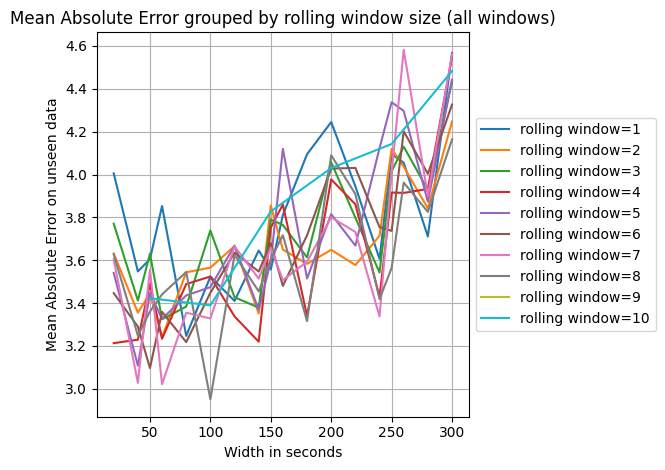

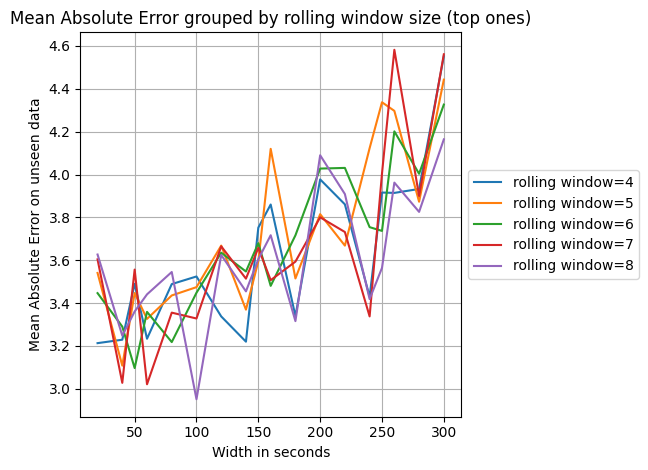

In [4]:
def plot_test_errors(df, top_ones):
    
    fig, ax = plt.subplots()

    for key, grp in df.groupby("rolling_window_size"):
        if top_ones and key in [1,2,3,9,10]:
            continue
        ax.plot(grp["width"], grp["MAE"], label=f"rolling window={key}")
    
    ax.set_xlabel("Width in seconds")
    ax.set_ylabel("Mean Absolute Error on unseen data")
    if top_ones:
        ax.set_title("Mean Absolute Error grouped by rolling window size (top ones)")
    else:
        ax.set_title("Mean Absolute Error grouped by rolling window size (all windows)")
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.grid(True)
    plt.tight_layout()
    plt.show()


os.chdir(PATH_TO_READ_SAVE_MODELS)
df = pd.read_csv('mae.csv')
df.columns = [ 'rolling_window_size', 'width', 'MAE']

plot_test_errors(df, False)
plot_test_errors(df, True)

* <u>Plot 2:</u> (Hybrid strategy) Pnl for different rolling windows per width

    * Note- Before running this. Need to run the file compute_best_rolling_window_per_width.py 10 times (once for each multiplier). Or save the dicts "dict_mul{multiplier}_pnl.pkl" I'll share in the PATH_TO_SAVE_RESULTS folder.
    * The purpose of this plot, similar to the previous plot, is to determine the rolling window size most suitable for a particular width model. In other words, <u>which rolling window size is the most useful in predicting the ref_price width seconds later.</u>
    * <u>How its calculated:</u> Taken care by the py script mentioned, for the 20% split exchange messages, I use multiplier=mul to predict prices for a width model (ref_prices width seconds later). This prediction is used in the same way except for the weighted mean. If predicted price higher, buy. The key difference between this way of calculating pnl and backtest.py is that the pnl locked in is due to the ref_price width seconds later instead of the cross price. This leads to a pnl for different rolling windows per width model.
    * The plot depicts the best pnl acheived per width model and which rolling multiplier was behind it.
    * Nice and large Pnls. This strat could be promising compared to the vanilla strats.

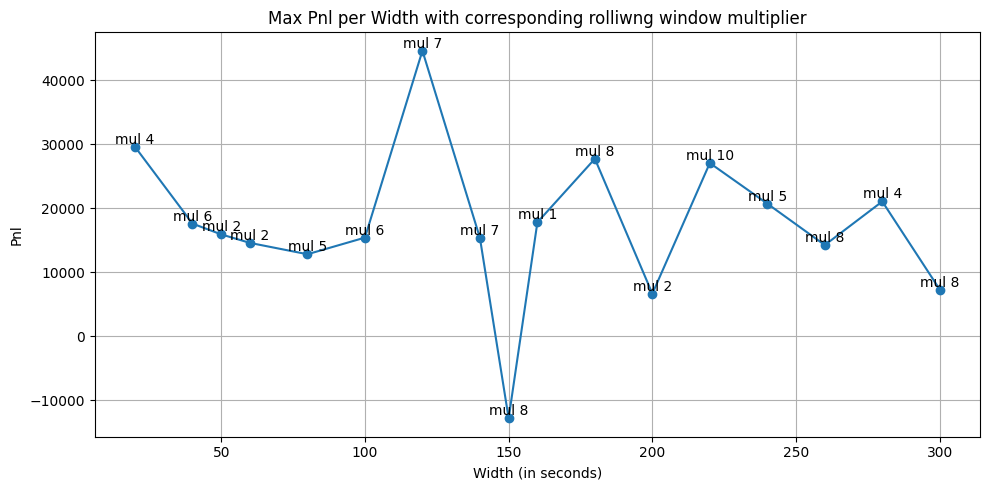

In [5]:
os.chdir(PATH_TO_SAVE_RESULTS)

pnl_per_w, index = [],[]
for multiplier in range(1,11):
    with open(f'dict_mul{multiplier}_pnl.pkl', 'rb') as f:
        my_dict = pickle.load(f)
    pnl_per_w.append(my_dict)
    index.append(multiplier)

all_pnls = pd.DataFrame(pnl_per_w, index=index)

sorted_columns = sorted(all_pnls.columns)
all_pnls = all_pnls[sorted_columns]

max_pnl_per_width = all_pnls.max()
best_multipliers = all_pnls.idxmax()

plt.figure(figsize=(10, 5))
plt.plot(sorted_columns, max_pnl_per_width.values, marker='o')


for i, width in enumerate(sorted_columns):
    pnl = max_pnl_per_width[width]
    mul = best_multipliers[width]
    plt.text(width, pnl, f'mul {mul}', ha='center', va='bottom')

plt.title('Max Pnl per Width with corresponding rolliwng window multiplier')
plt.xlabel('Width (in seconds)')
plt.ylabel('Pnl')
plt.grid(True)
plt.tight_layout()
plt.show()

* <u>Plot 3:</u> (Vanilla strategies) Pnl for different frequency strategies per rolling window size

    * Note- To run this, the corresponding (multiplier,freq) trained models should be saved in the PATH_TO_READ_SAVE_MODELS folder
    * As can be seen from the Plot 1, there is no clear multiplier(rolling window size) strategy that is a better performer so we <u>use this plot to determine the best performing frequency for each rolling window sized model used</u>
    * As can be seen from the plot, best Pnl is acheived with the (multiplier=6, frequency=100) pair. Pnl = 5223.6 (logs attached)
    * Overall, This way of making decisions for every exchange message looks like a granular approach. Using models for predicting every 20 secs aren't performing well as compared to frequency= 50 and 100.Freq=60 seems like the worst performer among them consistently across multipliers.


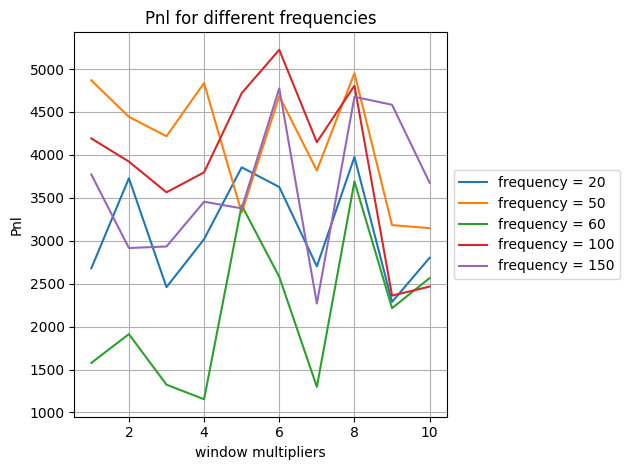

In [6]:
pnls,diffs={},{}
freq_list = [20,50,60,100,150]
best_pnl={}
for mul in range(1,11):
    current_best_pnl = -float('inf')
    best_pnl[mul]=0
    for freq in freq_list:
        pnls[(mul,freq)] = np.load(f'pnls_mul{mul}_freq{freq}.npy')
        diffs[(mul,freq)] = np.load(f'diffs_mul{mul}_freq{freq}.npy').ravel()

        pnl = np.sum(pnls[(mul,freq)])
        if pnl>current_best_pnl:
            current_best_pnl=pnl
            best_pnl[mul]=freq


fig, ax = plt.subplots()
for freq in freq_list:
    pnl = defaultdict(list)
    for mul in range(1,11):
        pnl[mul].append(np.sum(pnls[(mul,freq)]))

    ax.plot(pnl.keys(), pnl.values(), label=f'frequency = {freq}')

ax.set_xlabel('window multipliers')
ax.set_ylabel('Pnl')
ax.set_title('Pnl for different frequencies')
ax.legend(loc='center left', bbox_to_anchor=(1,0.5))
plt.grid(True)
plt.tight_layout()
plt.show()

* <u>Plot 4:</u> Pnl across thresholds for the best (mul,freq) pairs

    * This plot <u>helps us visualize an alternate way to use the same strategy adding another parameter Threshold</u> to a (multiplier, frequency) pair vanilla strategy.
    * Till now, we entered into a position for every exchange message. The idea of using a threshold to only enter into a position if the (predicted_price-current_price) > Threshold, naive way to model confidence in our model.
    * So we have 10 plots for each of the vanilla strategies i.e. 10 (multiplier, best_freq for that multiplier) pairs with different thresholds on the x-axis
    * Surprisingly, the best Pnl is acheived by taking a threshold of 0 consistently for all multipliers. Essentially, the threshold approach doesnt seem promising.

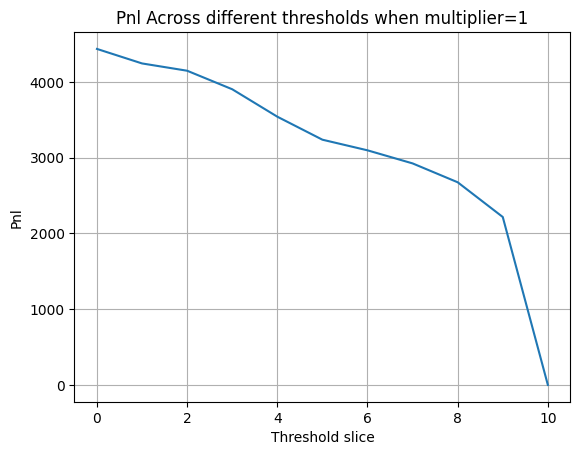

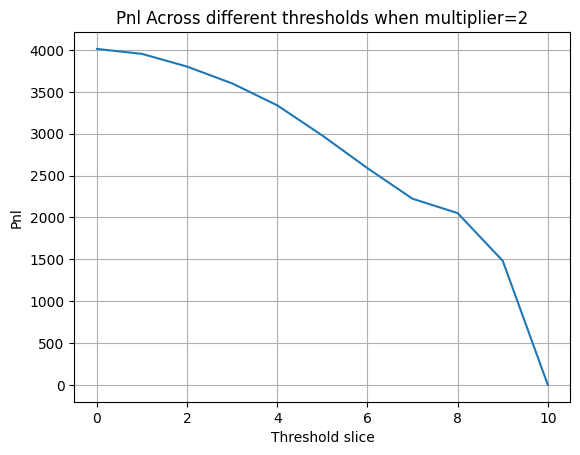

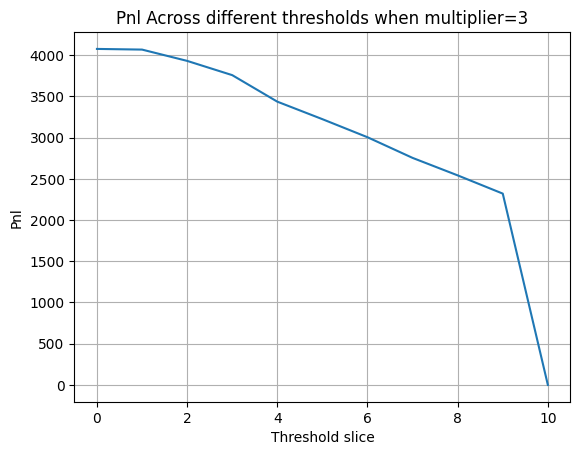

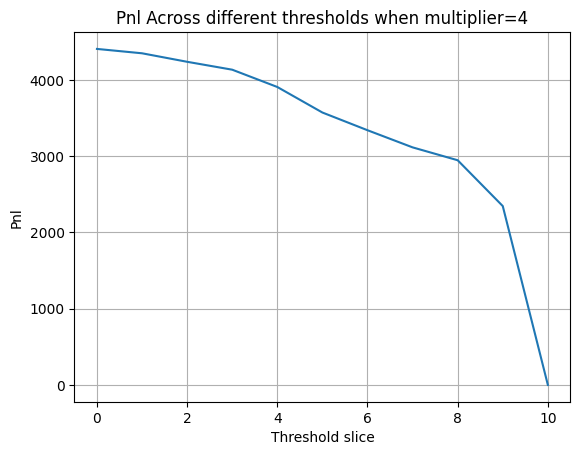

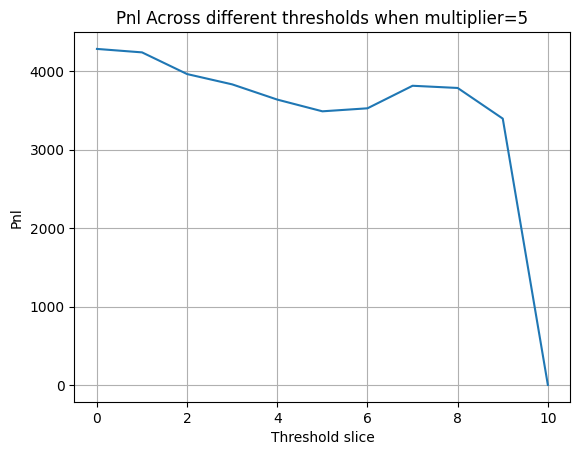

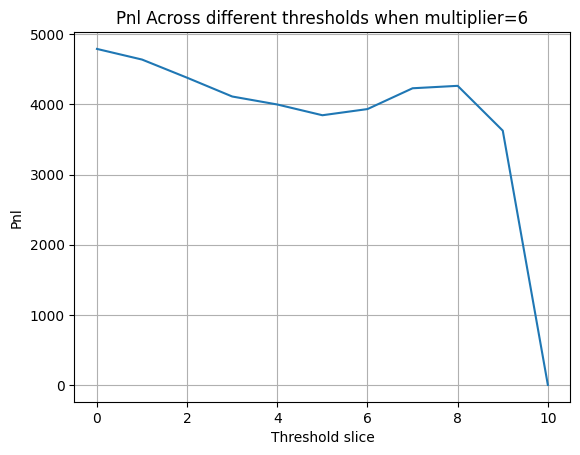

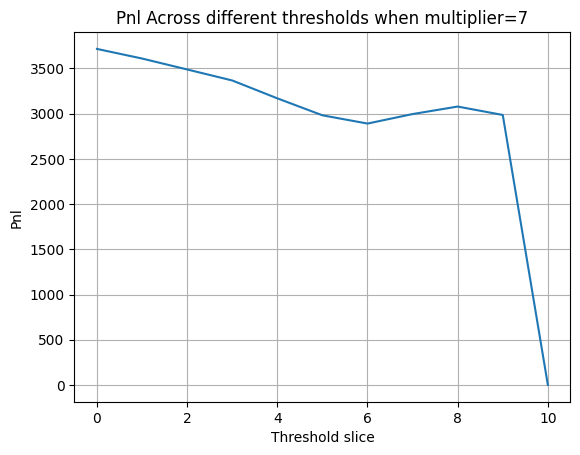

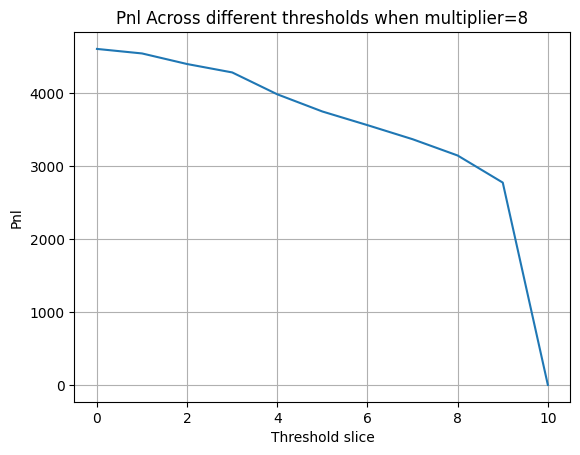

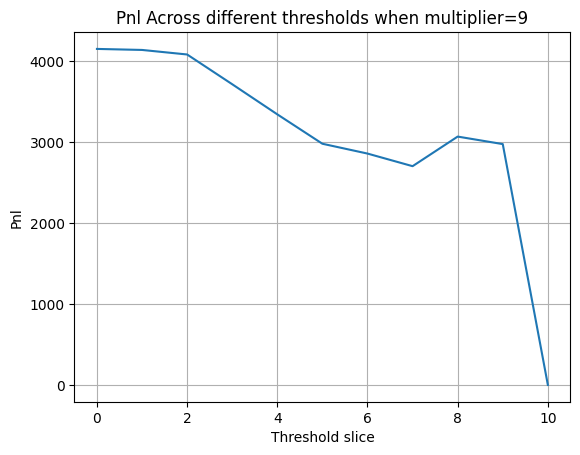

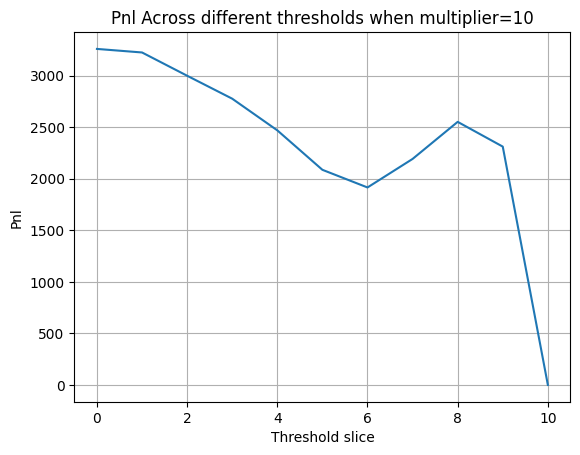

In [7]:
def plot_pnl_across_thresholds(multiplier, difference_array, pnl_array, num_bins):

    ref_prices = np.load('ref_prices.npy')
    
    difference_array = difference_array[ref_prices!=0]
    pnl_array = pnl_array[ref_prices!=0]
    ref_prices = ref_prices[ref_prices!=0]

    diff_percentage = difference_array/ref_prices*100
    
    sorted_diffs = np.sort(diff_percentage)
    quantile_edges = np.linspace(0, 1, num_bins + 1)
    bin_edges = np.quantile(sorted_diffs, quantile_edges)
    
    threshold_pnl = {}
    for i in range(11):
        threshold = bin_edges[i]
        pnl = np.sum(pnl_array[diff_percentage>threshold])
        threshold_pnl[i]=pnl
    
    plt.plot(threshold_pnl.keys(), threshold_pnl.values())
    plt.xlabel("Threshold slice")
    plt.ylabel("Pnl")
    plt.title(f"Pnl Across different thresholds when multiplier={multiplier}")
    plt.grid(True)
    plt.show()

for multiplier in range(1,11):
    best_freq_for_multiplier = best_pnl[multiplier]

    difference_array = diffs[(multiplier, best_freq_for_multiplier)]
    pnl_array = pnls[(multiplier, best_freq_for_multiplier)]
    plot_pnl_across_thresholds(multiplier, difference_array, pnl_array, num_bins=10)

***The final best 10 vanilla strategies:***

In [8]:
print('(Multiplier, best frequency for multiplier) = best pnl for the multiplier')
for mul in range(1,11):
    best_freq = best_pnl[mul]
    print(f'({mul}, {best_freq}) = {round(pnls[(mul, best_freq)].sum(),2)}')

(Multiplier, best frequency for multiplier) = best pnl for the multiplier
(1, 50) = 4868.17
(2, 50) = 4443.08
(3, 50) = 4216.78
(4, 50) = 4836.99
(5, 100) = 4718.0
(6, 100) = 5223.66
(7, 100) = 4147.24
(8, 50) = 4951.17
(9, 150) = 4583.2
(10, 150) = 3674.67


# 7 - Winning Strategy - Hybrid Strat
* Now for the winning strategy. As we saw the best pnl we get from vanilla multiplier strategies is 5.2K at best with the (multiplier=6, frequency=100) pair.
* But, the hybrid strategy showed alot of promise from plot 2 when testing different rolling windows per width. Best Pnls are pretty high with each width:

In [9]:
all_pnls

,20,40,50,60,80,100,120,140,150,160,180,200,220,240,260,280,300
1,2918.4433,-12667.8168,-18310.8862,-8861.0194,-616.9182,-5678.4262,-19308.6841,-14482.8263,-20869.1084,17789.4095,13794.4776,-18132.8008,-518.6288,4996.9762,2274.9742,-2071.7705,-2261.7985
2,25969.4633,-10777.9868,15906.2038,14576.2506,-17494.4682,11207.7838,33874.1987,-13739.0743,-16562.6942,-5756.2705,12492.4176,6637.2192,11795.1222,-26766.0138,11998.5722,11688.2047,-5198.1785
3,12331.6133,-14295.5568,-6313.0416,354.0184,-20811.7482,10742.4538,16689.9387,-1521.2643,-19767.4742,-3953.3605,10185.6076,-1290.4608,5163.2478,9919.0662,-6015.9926,-4280.7853,-1007.4241
4,29591.6933,-14076.4768,-7223.0204,-2609.6016,6439.1418,-27271.8062,21756.7887,-12257.5863,-13240.6290,-2707.5605,9782.7076,-17682.0816,-2286.9978,-676.0838,11020.8928,21051.7847,-10782.1441
5,13370.6533,-8410.8168,-31977.2304,-9869.5594,12803.2718,-4293.2162,14799.6587,-6947.7543,-24177.3142,-10044.9505,-3155.9524,-1795.7616,-13014.1970,20710.4962,11582.0574,-12148.1353,-9785.7741
6,-9090.7967,17589.9132,-14860.9858,-2632.0894,-12140.7682,15405.2838,39593.7707,11902.3757,-25848.8084,-2188.1205,15083.2376,-3630.4716,-9391.5770,13196.9062,2401.4574,-4150.7753,-20017.0141
7,1107.2533,5675.9332,-7606.3658,-5794.9916,7913.4618,5484.9238,44619.5587,15369.5857,-18466.2184,17592.0495,4478.0776,-3076.1516,1461.5972,5796.4762,3936.1822,1256.5447,6087.6715
8,-9088.4867,-20051.1368,-39699.9704,5121.7606,-5040.1482,-16825.2062,39765.4487,13571.4757,-12848.9442,-966.8305,27727.6456,2704.1904,-1491.8578,8625.5490,14239.1522,-7293.6453,7287.8915
9,-2851.9067,-136.3268,-23374.3358,-17277.5894,7836.7018,1053.8038,19937.7087,-6244.6743,-19316.9784,-6488.3705,718.9356,-7951.6208,-8007.9478,-4853.4738,-3693.1826,-11115.3653,-13051.2785
10,-12568.8067,7714.4432,-65338.9216,-23585.6294,-16413.1982,1381.1738,41828.2387,726.4557,-18999.9942,5239.9795,23544.9576,3163.7992,27058.4522,15649.4962,424.8874,3243.2547,437.0915


In [10]:
max_pnl_per_width.round(2)

20     29591.69
40     17589.91
50     15906.20
60     14576.25
80     12803.27
100    15405.28
120    44619.56
140    15369.59
150   -12848.94
160    17789.41
180    27727.65
200     6637.22
220    27058.45
240    20710.50
260    14239.15
280    21051.78
300     7287.89
dtype: float64

* Same file is used to test the backtest as before. Instructions to test-
    * Step 1: Run compute_best_rolling_window_per_width.py used for plot 2. This saves all the different Pnls for each (multiplier, width) pair.
    * Step 2: Run plotting.py to save the best_rolling_windows.pkl dictionary mapping width -> best multiplier. This file used in step 3.
    * Step 3: Run Backtest.py taking care of frequency (the 2nd argument) and setting HYBRID_STRAT=True in the beginning of the file.
        * Set HYBRID_STAT global variable to True
        * Make sure PATH_TO_READ_SAVE_MODELS has all the required models
        * Will need to run backtest.py as usual with 2 arguments. 1st argument for multiplier is meaningless as this is a hybrid strategy. 2nd argument is for the frequency.
    
* <u>Plot 5:</u> Pnl is considerably higher than the vanilla variants: Best Pnl ov=bserved with (hybrid optimal multiplier set, freq=100) pair = 13.2K (Log file shared: hybrid_100.log)

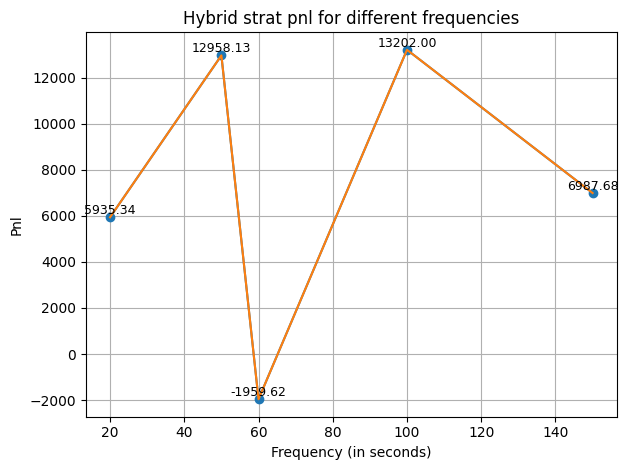

In [6]:
hybrid_pnls = {}
for frequency in [20,50,60,100,150]:
    pnls = np.load(f'pnls_hybrid_freq{frequency}.npy')
    hybrid_pnls[frequency]=pnls.sum()

x = list(hybrid_pnls.keys())
y = list(hybrid_pnls.values())

plt.plot(x, y, marker='o')
for xi, yi in zip(x, y):
    plt.text(xi, yi, f'{yi:.2f}', ha='center', va='bottom', fontsize=9)

plt.plot(hybrid_pnls.keys(), hybrid_pnls.values())
plt.title('Hybrid strat pnl for different frequencies')
plt.xlabel('Frequency (in seconds)')
plt.ylabel('Pnl')
plt.grid(True)
plt.tight_layout()
plt.show()  

# 8 - Possible Future Steps for Improvement

* All the models were trained on 1000 iterations. I did test briefly with 10,000 iterations for some variants. Mostly models were early stopping at <=5k but to maximize the capabilities of this strat/models, all the models should be retrained for larger number of iterations.
* I was only able to use freq=20,50,60,100,150. Due to limited resources, I was only able to train the models with width%20 or width%50=0 models for the 10 multipliers. Atleast 5-10 more should be investigated but the best model, strategy should still be in the ballpark of the above analysis.
* Some expensive stocks showed a very high MAE for their models compared to others. There should be better features to capture their variations, needs to be investigated.
* I wanted to test a more nuanced way of selecting features. Incrementally evaluate model performance improvement with chunks of feature groups added iteratively. Would be helpful to eliminate redundant and collinear features because code is somewhat computationally heavy currently. (Cant count the number of times my system crashed)